In [1]:
import math
import fileinput
import numpy as np
from scipy import integrate
from scipy import optimize
import random
import astropy
from astropy import units
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
#import winsound
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split #splitting data into training and test sets
from sklearn.preprocessing import StandardScaler #feature scaling
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import clear_output

In [3]:
from sklearn.metrics import mean_absolute_error, r2_score, f1_score,accuracy_score
from sklearn.linear_model import LinearRegression
#from lightgbm import LGBMRegressor
#from xgboost.sklearn import XGBRegressor
#from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_regression
from matplotlib import gridspec
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc
from numpy import absolute, mean, std

In [4]:
#keys_list = ['wav_rest','seds','gal_num','stellar_mass','dust_mass','metallicity','sfr']
#data_sed = np.load('all_sed.npz')
#data_filt = np.load('all_filter_z0.npz')
data_filt = np.load('npzFiles/all_filter_snap305.npz')
data_filt

In [5]:
# npz = np.load('all_filter_z0.npz')
# df= pd.DataFrame.from_dict({item: npz[item] for item in npz.files}, orient='index').T
# df.iloc[565]['gal_num']

In [6]:
for key in data_filt.keys():
    print(key)

wav_filt
filters
gal_num
stellar_mass
dust_mass
metallicity
sfr


In [7]:
# testing that data was all stored correctly

In [8]:
stellar_masses = data_filt['stellar_mass'] # solar masses
dust_masses = data_filt['dust_mass'] # solar masses
sfrs = data_filt['sfr'] # msun/yr
metal = data_filt['metallicity'] # individual, not scaled to sun
gal_nums = data_filt['gal_num'] # number assigned by group code

filters = data_filt['filters']*units.erg/units.s/units.cm**2/units.micron
wav_filt = data_filt['wav_filt'] # micron

In [9]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=68, Om0=0.3, Tcmb0=2.725)
age0 = cosmo.age(0)

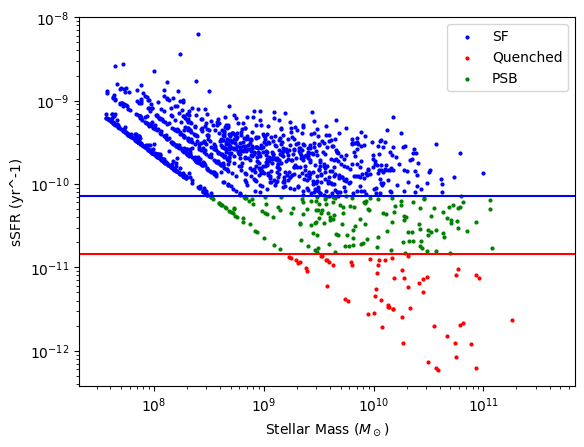

172

In [10]:
ssfr = sfrs/stellar_masses
tH = age0.to('yr').value
cut1 = ssfr > 1/tH
cut2 = ssfr < 0.2/tH
plt.scatter(stellar_masses[cut1],ssfr[cut1],label = 'SF',color = 'blue',s=4)
plt.scatter(stellar_masses[cut2],ssfr[cut2],label = 'Quenched',color = 'red',s = 4)
plt.scatter(stellar_masses[~(cut1 | cut2)],ssfr[~(cut1 | cut2)],
            label = 'PSB',color = 'green', s = 4)

plt.axhline(1/tH,color = 'blue')
plt.axhline(0.2/tH,color = 'red')
plt.xlabel('Stellar Mass $(M_\\odot)$')
plt.ylabel('sSFR (yr^-1)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
plt.close()
len(ssfr[~(cut1 | cut2)])

In [11]:
binwidth = 100 #Myr
def get_galaxy_SFH_fit_style(massform,tform,nbins = 50):
    t_H = tH*10**-6
    tbinmax = (t_H * 0.8) #* 1e9 #earliest time bin goes from age = 0 to age = 2.8 Gyr
    lim1, lim2 = 8.0-6,8.477-6#7.47, 8.0 #most recent time bins at 30 Myr and 100 Myr ago
    agelims = [0,lim1] 
    agelims += np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist()
    agelims += [np.log10(t_H)]#*1e9)]
      #print(agelims)
    agebins = np.array([agelims[:-1], agelims[1:]])
    #print(agebins)
    #print(10**agebins)
    binsl =(t_H-10**np.array(agelims))[::-1]
    binsl = np.arange(0, t_H, 250)
    #print(tH, agelims, binsl, '\n')
    #print(binsl)
    msums, binsedge, binnumber = scipy.stats.binned_statistic(tform, massform, 
                                                              statistic='sum',bins=binsl)
    msums[np.isnan(msums)] = 0
    timediff = np.diff(binsedge)
    sfr_fit = msums/timediff/10**6
    sfr_plot = []
    time_plot = []
    for i in range(len(sfr_fit)):
        time_plot.append(binsedge[i])
        time_plot.append(binsedge[i+1])
        sfr_plot.append(sfr_fit[i])
        sfr_plot.append(sfr_fit[i])
    return time_plot,sfr_plot,sfr_fit
        
    
#this function is given to scipy.stats.binned_statistics 
#and acts on the particle masses per bin to give total(Msun) / timebin
def get_massform(massform):
        return np.sum(massform) / (binwidth * 1e6)
def get_galaxy_SFH(file_):
    dat = pd.read_pickle(file_)
    massform = np.array(dat['massform'][np.where(np.asarray(dat['id'])==galaxy_id)[0][0]])
    tform =  np.array(dat['tform'][np.where(np.asarray(dat['id'])==galaxy_id)[0][0]])*1000
    #convert from Gyr to Myr
    t_H = np.max(tform)
    bins = np.arange(np.min(tform), np.max(tform), binwidth) #can use whatever bin size/start/end that fit your problem
    #bins = np.arange(0, t_H, binwidth) #can use whatever bin size/start/end that fit your problem
    #print(bins)
    sfrs, bins, binnumber = scipy.stats.binned_statistic(tform, massform, 
                                                         statistic=get_massform, bins=bins)
    sfrs[np.isnan(sfrs)] = 0
    bincenters = 0.5*(bins[:-1]+bins[1:])
    sfh = sfrs
   # get_galaxy_SFH_fit_style(massform,tform)
    # x,y,z = get_galaxy_SFH_fit_style(massform,tform,nbins = 10)
    x,y,z = get_galaxy_SFH_fit_style(massform,tform)
    return bincenters, sfh, x, y, z

def arr_double(arr):
    #print(np.shape(arr))
    new_arr = []
    for val in arr[0]:
        new_arr.append(val)
        new_arr.append(val)
    return np.array(new_arr)

In [12]:
import scipy.stats
import pandas as pd

path = '/orange/narayanan/d.zimmerman/simba/m25n512/snap305/snap305_sfhs.pickle'

#sfh_plot = []
#time_plot = []

plot_info = {}
sfh_to_fit = []

for galaxy_id in gal_nums:
#for galaxy_id in gal_nums[:10]:
    #galaxy_id = np.random.randint(0,3658)#592
    time, sfh, time_prosp,sfh_prosp, sfr_fit = get_galaxy_SFH(path)
    plot_info[galaxy_id] = [time, sfh, time_prosp,sfh_prosp]
    sfh_to_fit.append(sfr_fit)

# plt.plot(time, sfh,label = 'binned true SFH')
# plt.plot(time_prosp,sfh_prosp,label = 'Prospector-like binned true SFH')
# plt.ylabel('SFR [M$_{\odot}/$yr]')
# plt.xlabel('t$_H$ [Myr]')
# plt.title(f'Galaxy {galaxy_id}')
# plt.legend()
# plt.show()
# plt.close()


In [13]:
# X, y = make_regression(random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# reg = GradientBoostingRegressor(random_state=0)
# reg.fit(X_train, y_train)
# reg.predict(X_test[1:2])
# reg.score(X_test, y_test)

In [14]:
# construct array of properties I want to predict
# combined_y = np.array(sfh_to_fit).reshape(-1,1)
# combined_X = np.array(filters).reshape(-1,1)
combined_y = np.array(sfh_to_fit)
combined_X = np.array(filters)
print(np.shape(combined_y))
print(np.shape(combined_X))
#combined_y

(1733, 55)
(1733, 35)


In [15]:
# train_X, test_X, train_y, test_y = train_test_split(
#     combined_X, combined_y, random_state=117, test_size=0.6)
train_X, test_X, train_y, test_y = train_test_split(
    combined_X, combined_y, random_state=117)
#-------------------------------------------
# train_Xs = StandardScaler().fit(train_X).transform(train_X)
# test_Xs = StandardScaler().fit(train_X).transform(test_X)
# for xx in [train_X, test_X, train_y, test_y]:
#     # print(np.shape(xx),xx, "\n")
#     print(np.shape(xx))
#-------------------------------------------
trainInds = []
for train in train_X:
    trainInds.append(gal_nums[np.where(combined_X==train)[0][0]])
testInds = []
for test in test_X:
    testInds.append(gal_nums[np.where(combined_X==test)[0][0]])
trainInds = np.sort(np.asarray(trainInds))
testInds = np.sort(np.asarray(testInds))
print('Training Set:', len(trainInds), trainInds[:10])
print('Testing Set:', len(testInds), testInds[:10])

Training Set: 1299 [ 1  6  9 12 14 15 18 20 21 22]
Testing Set: 434 [ 5 37 44 47 55 57 63 65 69 72]


In [16]:
# # paramGrid = {
# #     'max_features': [None, "sqrt", 2],
# #     'n_estimators': [50,100,150],
# #     'criterion': ["squared_error", "friedman_mse", "poisson"]
# #             }
# # gridSearch = GridSearchCV(RandomForestRegressor(random_state=0), 
# #                           paramGrid, cv=2, verbose=3, n_jobs=4)
# paramGrid = {
#     'min_samples_split': [3,5,10],
#     'min_samples_leaf': [3,5,10],
#     'max_depth' : ['None', 3,5,10],
#     'criterion': ["squared_error", "friedman_mse", "poisson", "absolute_error"]
#             }
# gridSearch = GridSearchCV(DecisionTreeRegressor(random_state=0), 
#                           paramGrid, cv=3, verbose=0, n_jobs=4)
#                           #paramGrid, cv=2, verbose=3)
# gridSearch.fit(train_X, train_y);
# print("Best parameters: {}".format(gridSearch.best_params_))
# print("Best model: {}".format(gridSearch.best_estimator_))
# print("Best score: {}".format(gridSearch.best_score_))
# print("Train score: {:.2f}".format(gridSearch.score(train_X, train_y)))
# print("Test score: {:.2f}".format(gridSearch.score(test_X, test_y)))

In [17]:
# results = pd.DataFrame(gridSearch.cv_results_)
# scores = np.array(results.mean_test_score).reshape(4,4)

# toplot_x = list(gridSearch.param_grid.keys())[0]
# toplot_y = list(gridSearch.param_grid.keys())[1]

# ax = sns.heatmap(scores[::-1,:], annot=True, fmt=".2f", 
#                  xticklabels=np.array(gridSearch.param_grid[toplot_x]).astype(str),
#                  yticklabels=np.array(gridSearch.param_grid[toplot_y][::-1]).astype(str)
#                  )
# ax.set_xlabel(toplot_x);
# ax.set_ylabel(toplot_y);

In [18]:
# guess_sfh = model.predict(test_X)
# guess_classes = np.zeros_like(guess_sfh)
# test_classes = np.zeros_like(guess_sfh)
# cutoff=0.2
# guess_classes[guess_sfh > cutoff] = 1.0 
# test_classes[test_y > cutoff] = 1.0
# print(accuracy_score(test_classes, guess_classes))
# print(np.mean(f1_score(test_classes,guess_classes, average=None)))
# print(mean_absolute_error(test_classes,guess_classes))
# print(mean_absolute_error(test_classes,guess_classes))

In [19]:
#model = RandomForestRegressor(verbose=0)
# model = DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
#                       min_samples_leaf=5, min_samples_split=3)
#model = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=300)
#model = MultiOutputRegressor(LinearSVR())
#model = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0,loss='squared_error'))
#model = DecisionTreeRegressor() #requires feature scaling?
#model = MultiOutputRegressor(HistGradientBoostingRegressor())
#--------------------------------------
#model = LinearRegression()
#model = KNeighborsRegressor()
model = RandomForestRegressor(verbose=0, random_state=1)
#--------------------------------------
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, combined_X, combined_y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('Mean Absolute Error (MAE): %.3f +/- %.3f' % (mean(n_scores), std(n_scores)))
#--------------------------------------
model.fit(train_X, train_y)
#[mean_squared_error(y_test, y_pred) for y_pred in model.staged_predict(X_test)]
trainScore = model.score(train_X, train_y)
testScore = model.score(test_X, test_y)
guess_sfh = model.predict(test_X)
#--------------------------------------
mseTest = mean_squared_error(test_y, guess_sfh)
mseTrain = mean_squared_error(train_y, model.predict(train_X))
print(f"Score: {trainScore*100:.1f}% (training), {testScore*100:.1f}% (testing)")
print(f"Mean Squared Error (MSE): {mseTrain:.2f} (training), {mseTest:.2f} (testing)")

Mean Absolute Error (MAE): 0.349 +/- 0.124
Score: 93.3% (training), 12.9% (testing)
Mean Squared Error (MSE): 1.13 (training), 3.42 (testing)


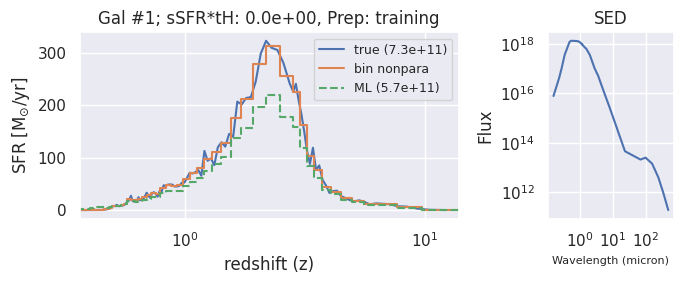

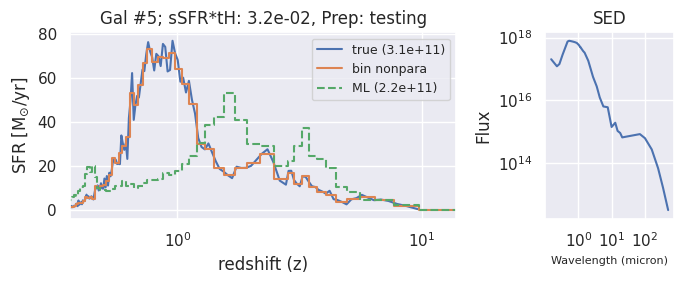

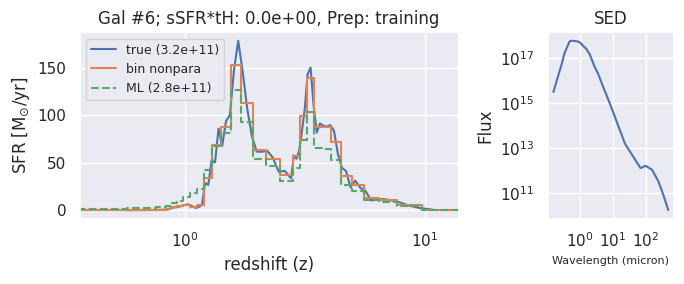

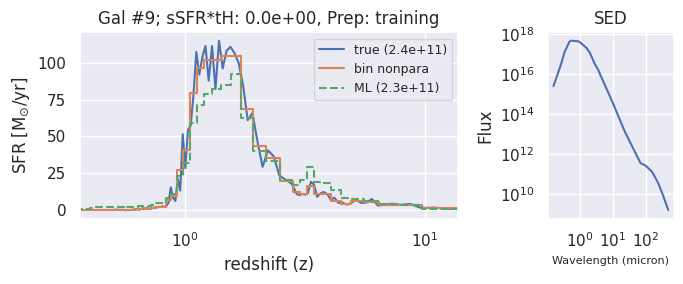

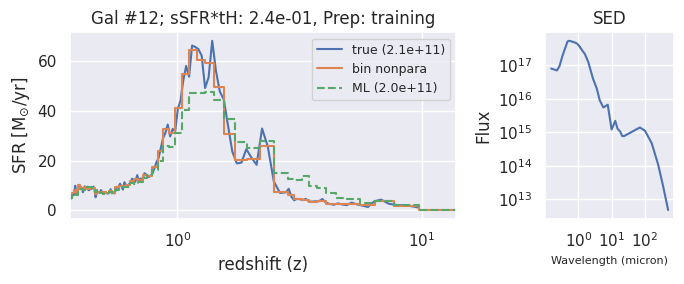

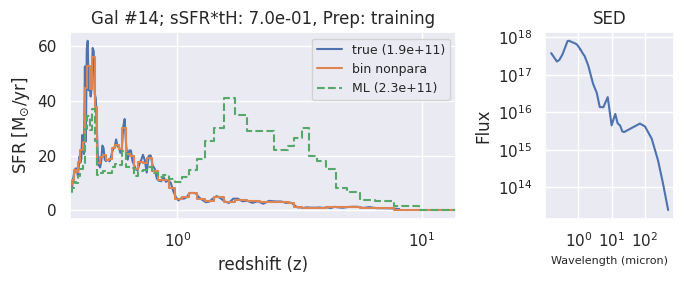

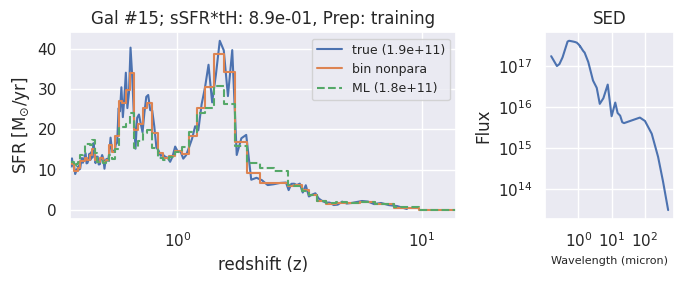

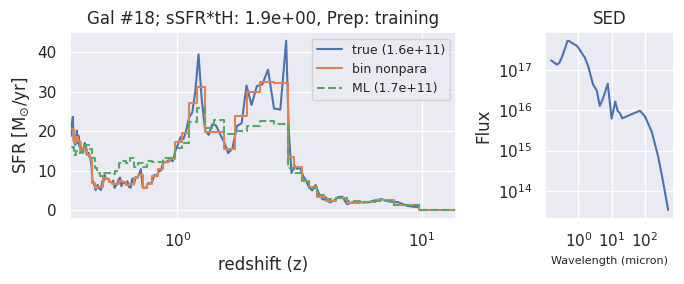

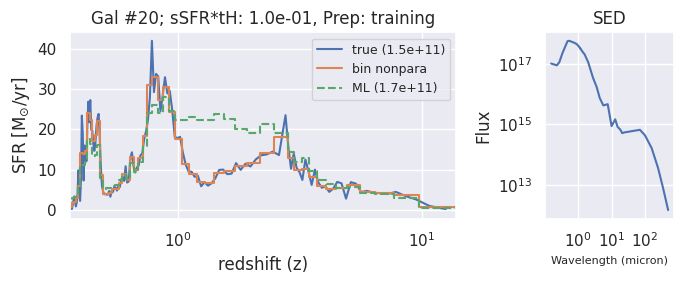

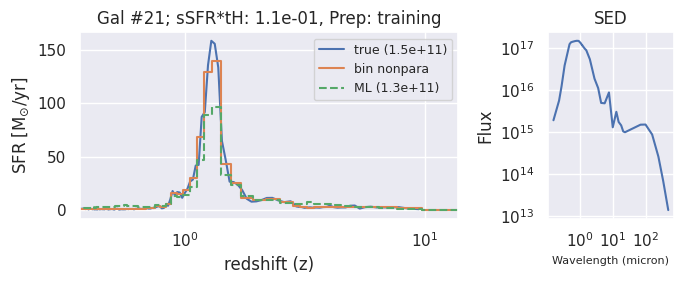

In [46]:
redX = True # set false to have time as the x axis
from astropy import units as u;import yt;sns.set(style='darkgrid')
yt_cosmo = yt.utilities.cosmology.Cosmology(hubble_constant=0.68, omega_lambda = 0.7, omega_matter = 0.3)
t2z = lambda tt: [yt_cosmo.z_from_t((t*u.Myr).to(u.s).value) for t in tt]
# z2t = lambda tt: [yt_cosmo.t_from_z(t) for t in tt]
perm = np.random.permutation(len(gal_nums))
for idx in range(10):
#for idx in perm[:50]:
    plt.figure(figsize=(7,3))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    gnum = gal_nums[idx]
    fil = filters[idx]
    wav = wav_filt
    res = plot_info[gnum]
    #print(gnum)    
    #print(ssfr[idx]*tH)
    x= np.asarray(res[0])*1e6
    y= np.asarray(res[1])
    a1 = auc(x,y)
    ax = plt.subplot(gs[0])
    #ax2 = ax.twiny()
    ax.set(ylabel='SFR [M$_{\odot}/$yr]')
    reds = None
    if redX:
        ax.plot(t2z(res[0]), res[1],label = f'true ({a1:.1e})')
        res[2][0] = 10
        reds=t2z(res[2])
        ax.plot(reds,res[3],label = 'bin nonpara')
        ax.set(xlabel='redshift (z)', xlim=(min(reds),15))
        ax.set(xscale='symlog')
#        ax2 = ax.secondary_xaxis("top", functions=(z2t, t2z))
    else:
        ax.plot(res[0],res[1],label = f'bin true (int: {a1:.1e})')
        ax.plot(res[2],res[3],label = 'bin nonpara')
        ax.set(xlabel='t$_H$ [Myr]')
#        ax2 = ax.secondary_xaxis("top", functions=(t2z, z2t))
    #pred = model.predict(filters[idx])
    pred = model.predict(filters[idx].reshape(1, -1))
    #pred = model.predict(filters[idx].reshape(-1, 1))
    x= np.asarray(res[2])*1e6
    y = np.asarray(arr_double(pred))
    a2 = auc(x,y)
    if redX: ax.plot(reds,arr_double(pred),label = f'ML ({a2:.1e})', ls='--')
    else: ax.plot(res[2],arr_double(pred),label = f'ML ({a2:.1e})', ls='--')
    prep = None
    if gnum in trainInds: prep='training'
    if gnum in testInds: prep='testing'
    plt.title(f'Gal #{gnum}; sSFR*tH: {np.round(ssfr[idx]*tH,5):.1e}, Prep: {prep}', fontsize=12)
    plt.legend(fontsize=9)
    ax = plt.subplot(gs[1])
    plt.loglog(wav, fil)
    plt.xlabel('Wavelength (micron)', size=8)
    plt.ylabel('Flux')
    plt.title('SED')
    plt.tight_layout()
    plt.show()
    plt.close()

In [21]:
# rfre_sfh_filt = RandomForestRegressor(verbose=0, 
#                                       criterion='poisson',
#                                       max_features=2,
#                                       n_estimators=50
#                                      )
# rfre_sfh_filt.fit(train_X_combined,train_y_combined)
# print(rfre_sfh_filt.score(test_X_combined,test_y_combined))
# guess_sfh = rfre_sfh_filt.predict(test_X_combined)

In [22]:
# perm = np.random.permutation(len(gal_nums))
# for idx in range(10):#perm[:50]:
#     gnum = gal_nums[idx]
#     res = plot_info[gnum]
#     #print(gnum)    
#     #print(ssfr[idx]*tH)
#     plt.plot(res[0],res[1],label = 'binned true SFH')
#     plt.plot(res[2],res[3],label = 'binned true nonpara SFH')
#     rf_predict = rfre_sfh_filt.predict(filters[idx].reshape(1, -1))
#     plt.plot(res[2],arr_double(rf_predict),label = 'RF predicted SFH')
#     plt.ylabel('SFR [M$_{\odot}/$yr]')
#     plt.xlabel('t$_H$ [Myr]')
#     plt.title(f'Galaxy {gnum}, sSFR param: {np.round(ssfr[idx]*tH,5)}')
#     plt.legend()
#     plt.show()
#     plt.close()

In [23]:
# first test for random forest stellar mass predictions
# training set and test set calculation
#plt.scatter(train_y_combined[:,0],rfre_stel.predict(train_X_combined),label = 'train',alpha=0.5)
# plt.scatter(test_y_combined[:,0],guess_stel,label = 'test sed',alpha=0.5)
# plt.scatter(test_y_combined2[:,0],guess_stel2,label = 'test filter',alpha=0.5)
# # set range by min/max relevant
# range_low = min(np.min(test_y_combined[:,0]),np.min(guess_stel),
#                 np.min(rfre_stel.predict(train_X_combined)))
# range_high = max(np.max(test_y_combined[:,0]),np.max(guess_stel),
#                  np.max(rfre_stel.predict(train_X_combined)))
# plt.xlim(range_low,range_high)
# plt.ylim(range_low,range_high)
# plt.plot(np.linspace(range_low,range_high,1000),np.linspace(range_low,range_high,1000),color='r')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('True $M_*$ ($M_{\\odot}$)')
# plt.ylabel('Predicted $M_*$ ($M_{\\odot}$)')
# plt.title('Initial Stellar Mass Random Forest')
# plt.legend()
# plt.show()
# plt.close()

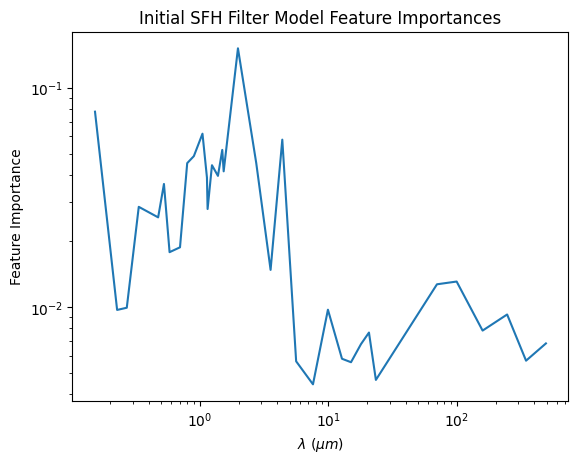

In [24]:
plt.plot(data_filt['wav_filt'],model.feature_importances_)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\lambda$ ($\\mu m$)')
plt.ylabel('Feature Importance')
plt.title('Initial SFH Filter Model Feature Importances')
plt.show()
plt.close()

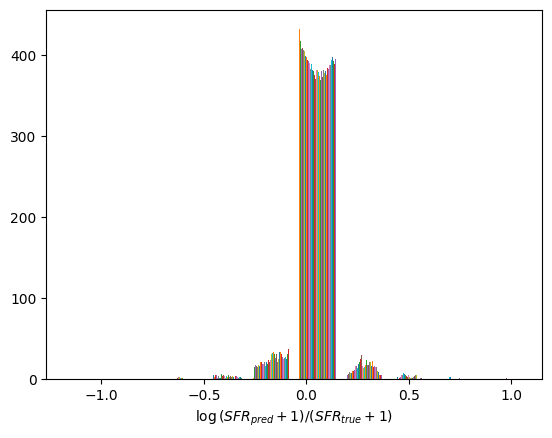

In [25]:
plt.hist(np.log10((guess_sfh+1)/(test_y+1)))
plt.xlabel('$\\log{(SFR_{pred}+1)/(SFR_{true}+1)}$')
plt.show()
plt.close()

<Axes: ylabel='Density'>

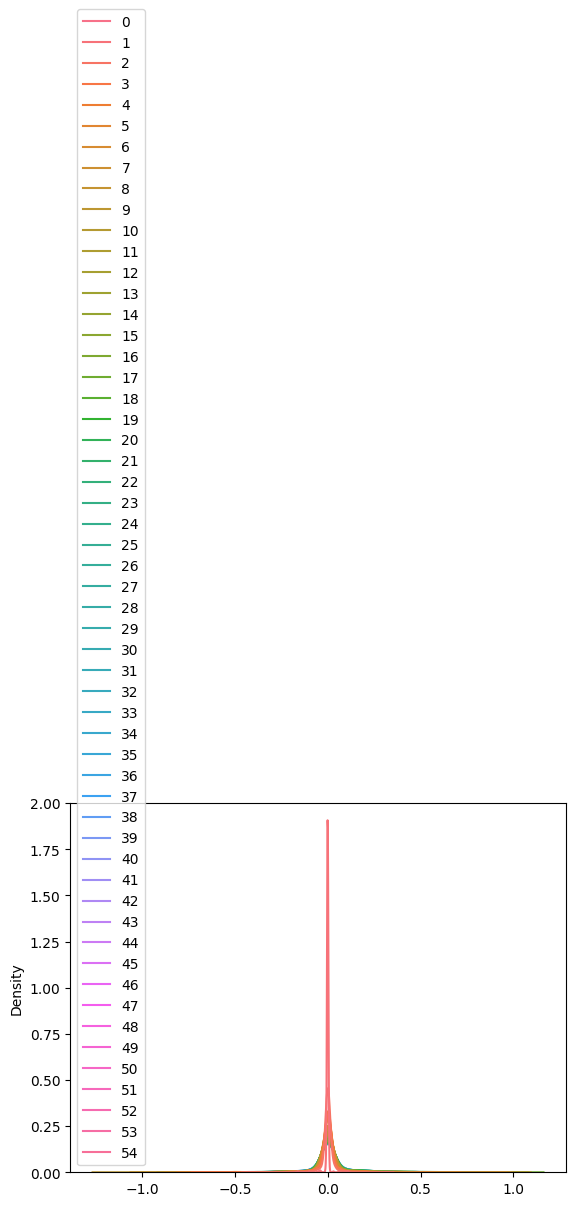

In [26]:
sns.kdeplot(np.log10((guess_sfh+1)/(test_y+1)))
